# Prediction of Prices of Used Cars Using Polynomial Regression

## DATA SCRAPING
- The data is being scraped from www.cars.com
- This is a well structured source for used car listings and is generous to scrapers
- Check www.cars.com/robots.txt for more information on what the website allows

### Package Imports:

In [237]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import re
import pandas as pd
import os
import datetime
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from yellowbrick.regressor import ResidualsPlot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

#### Let's take a moment to think about this problem from the perspective of the end-user. If you were to buy a car, what are the key metrics you would look for?

Well, off the top of my head, I'd definitely want to know how old the car is, the number of miles on it, the brand, transmission, drivetrain, engine capacity and the interior/exterior color.

#### Let's code them up!

In [162]:
#initializing all lists where each list is a feature
names = [] #The year of manufacture is embedded in the name and we'll have to extract it using a regex
prices = []
miles = []
transmissions = []
drivetrains = []
ext_colors = []
int_colors = []
engine_caps = []

#We'll also need the following regex to extract a few of the features
myreg = re.compile(' [A-Za-z]*\\n')


#### Before we begin web-scraping, let's pause and look at how the data is structured in the website. Here's a snapshot:
![title](Project_2_files/Main.png)
#### Looks like most of the data we need is available in the listing overview, but it looks like we'll have to look into each listing to find the engine capacity. Here's what an individual listing looks like:
![title](Project_2_files/Inside.png)


#### To implement an MVP, let's scrape the first 50 pages with 100 listings per page.
It looks like the website is hardcoded to give us only 50 pages and a maximum of 100 listings per page. To circumvent this, we'll have to use filters independent of each other to get the listings we can't access traditionally. That part is beyond the scope of the project at the moment, so let's limit our search to the first 5000 listings of sedans.

In [163]:
index = -1
#Iterate through all 50 pages
for _ in range(1, 51):
    #print (_)
    url = 'https://www.cars.com/for-sale/searchresults.action/?bsId=20211&cpoId=28444&page={}&perPage=100&rd=99999&searchSource=GN_REFINEMENT&shippable-dealers-checkbox=true&showMore=true&sort=relevance&zc=10016&userSetIxt=true&localVehicles=false'
    url = url.format(_)
    #print(url)
    response = requests.get(url)
    #print(response)
    sauce = response.text
    soup = BeautifulSoup(sauce)
    pre_names = soup.findAll('h2',{'class':'listing-row__title'})
    for name in pre_names:
        names.append(name.text.strip())
    pre_price = soup.findAll('span', {'class':'listing-row__price'})
    for price in pre_price:
        prices.append(price.text.strip())
    pre_miles = soup.findAll('span', {'class':'listing-row__mileage'})
    for mile in pre_miles:
        miles.append(mile.text.strip())
    pre_stats = soup.findAll('ul', {'class':'listing-row__meta'})
    for i in pre_stats:
        ext_colors.append(myreg.findall(i.contents[1].text)[0].strip())
        int_colors.append(myreg.findall(i.contents[3].text)[0].strip())
        transmissions.append(myreg.findall(i.contents[5].text)[0].strip())
        drivetrains.append(myreg.findall(i.contents[7].text)[0].strip())
        #print('end')
    #The following code is to get the engine capacity value
    #Get all listing links per page
    pre_links = soup.findAll('a', {'class':'shop-srp-listings__listing'})
    #index = -1
    #Open each link to get the required data
    for link in pre_links:
        index+=1
        listing_link = ('https://www.cars.com%s'%link.get('href'))
        #print(listing_link)
        response1 = requests.get(listing_link)
        #print(response1)
        sauce1 = response1.text
        soup1 = BeautifulSoup(sauce1)
        pre_enginecap = soup1.findAll('li', {'class':'vdp-details-basics__item'})
        for i in pre_enginecap:
            flag = 0
            if 'Eng' in i.text.strip():
                engine_caps.append(i.text.strip())
                #print(i.text.strip())
        if index == len(engine_caps):
            engine_caps.append('NaN')
            


#### Finally, we have our required features and target. Let's quickly check that we haven't missed any values (which could upset the order of the data):

In [164]:
#Lengths of scraped lists
#FEATURES:
print('Names: %s'%len(names))
print('Miles: %s'%len(miles))
print('Transmissions: %s'%len(transmissions))
print('Drivetrains: %s'%len(drivetrains))
print('Ext_Colors: %s'%len(ext_colors))
print('Int_Colors: %s'%len(int_colors))
print('Engine_Caps: %s'%len(engine_caps))

#TARGET:
print('\n\nPRICES: %s'%len(prices))


Names: 5000
Miles: 5000
Transmissions: 5000
Drivetrains: 5000
Ext_Colors: 5000
Int_Colors: 5000
Engine_Caps: 5000


PRICES: 5000


#### Everything looks okay. Now it's time to put it all together in one table:

In [165]:
#Create DF with the lists of features
df = {'NAME': names, 'MILES': miles, 'TRANSMISSION': transmissions, 'DRIVETRAIN': drivetrains
      , 'EXT_COLOR': ext_colors, 'INT_COLOR': int_colors, 'ENGINE_CAP': engine_caps, 'PRICE': prices}
df = pd.DataFrame(df, columns=df.keys())


In [166]:
df.describe()

,NAME,MILES,TRANSMISSION,DRIVETRAIN,EXT_COLOR,INT_COLOR,ENGINE_CAP,PRICE
count,5000,5000,5000,5000,5000,5000,5000,5000
unique,1208,4755,5,4,13,13,447,3117
top,2016 Mercedes-Benz E 350 4MATIC,"36,096 mi.",Automatic,FWD,Black,Black,Engine: 2.0L I4 16V GDI DOHC Turbo,"$18,995"
freq,80,3,3710,2830,1189,2695,495,22


In [167]:
df.head()

,NAME,MILES,TRANSMISSION,DRIVETRAIN,EXT_COLOR,INT_COLOR,ENGINE_CAP,PRICE
0,2015 Audi A4 2.0T Premium,"39,810 mi.",CVT,FWD,Black,Black,Engine: 2.0L I4 16V GDI DOHC Turbo,"$17,495"
1,2016 Mercedes-Benz E 400 4MATIC,"54,713 mi.",Automatic,AWD,Red,Brown,Engine: Twin Turbo Premium Unleaded V-6 3.0 L/183,"$34,993"
2,2016 Mercedes-Benz CLA 250,"28,029 mi.",Automanual,AWD,White,Black,Engine: Intercooled Turbo Premium Unleaded I-4...,"$25,577"
3,2015 Mercedes-Benz CLA 250 4MATIC,"28,253 mi.",Automatic,AWD,Black,Black,Engine: 2.0L I4 16V GDI DOHC Turbo Flexible Fuel,"$22,000"
4,2016 Honda Accord Touring,"36,467 mi.",Automatic,FWD,White,White,Engine: 3.5L V6 24V MPFI SOHC,"$23,087"


In [168]:
df.dtypes

NAME            object
MILES           object
TRANSMISSION    object
DRIVETRAIN      object
EXT_COLOR       object
INT_COLOR       object
ENGINE_CAP      object
PRICE           object
dtype: object

## DATA TRANSFORMATION
Before we get into implementing models, we'll have to first make sure all the data is in the right format and data-types. Thus, we begin the no-so-fun process of data transformations:

In [169]:
#Check if your transformations worked for all rows using sum(df[<insert feature here>].value_counts())

In [192]:
#Create a new df containing the final features
df_final = pd.DataFrame()
#df_final = pd.read_pickle('df_final.pkl')

In [171]:
#Extracting Year and converting it to the right format 
#We're using int and not datetime because we want the model to understand that 2016<2018 when predicting price
df_final['YEAR'] = pd.to_numeric(df['NAME'].str[:4])

In [172]:
#Get brand names
df_final['BRAND'] = df['NAME'].apply(lambda brand: re.search(r'[A-Za-z-]+', brand)[0])

In [173]:
#Format miles and prices to integers
df_final['MILES'] = pd.to_numeric(df['MILES'].apply(lambda miles: ''.join(re.findall(r'[0-9]*', miles))))
df_final['PRICE'] = pd.to_numeric(df['PRICE'].apply(lambda miles: ''.join(re.findall(r'[0-9]*', miles))))

In [174]:
#Following is a function to return engine capacity value as a float
def engine_cap(e_c):
    if e_c == 'NaN':
        #print (e_c)
        return ('NaN')
    elif re.search(r'[0-9]\.[0-9 ]*L',e_c) is None:
        #print (e_c)
        return ('NaN')
        
    else:
        #print(e_c)
        #print ((re.search(r'[0-9. ]+L',e_c)[0]).strip()) 
        temp = ((re.search(r'[0-9]\.[0-9 ]*L',e_c)[0]).strip())
        temp =  temp.replace(' ', '')
        return float(temp.replace('L', ''))

In [175]:
#We map above function to the original ENGINE_CAP column
df_final['ENGINE_CAP'] = df['ENGINE_CAP'].map(engine_cap)

In [176]:
#Adding the rest of the features that don't need formatting/transformation
df_final[['TRANSMISSION', 'DRIVETRAIN', 'EXT_COLOR', 'INT_COLOR']] = df[['TRANSMISSION', 'DRIVETRAIN'
                                                                         , 'EXT_COLOR', 'INT_COLOR']]


In [177]:
#Converting 'NaN' strings to NoneType
df_final.replace('NaN', np.nan, inplace=True)

In [193]:
df_final.tail(10)

,YEAR,BRAND,MILES,PRICE,ENGINE_CAP,TRANSMISSION,DRIVETRAIN,EXT_COLOR,INT_COLOR
4990,2015,INFINITI,45320,30998,5.6,Automatic,RWD,Gray,Gray
4991,2018,INFINITI,21151,36588,3.7,Automatic,AWD,Blue,Other
4992,2015,Volvo,33517,17997,2.0,Automatic,FWD,Blue,Beige
4993,2016,Nissan,28410,17867,2.5,CVT,FWD,Silver,Gray
4994,2018,Acura,496,44929,3.5,Automatic,FWD,Black,Black
4995,2016,BMW,38656,35990,3.0,Automatic,AWD,White,Brown
4996,2016,BMW,54249,49994,4.4,Automatic,AWD,Gray,Beige
4997,2015,INFINITI,36399,24988,3.7,Automatic,AWD,Black,Gray
4998,2018,INFINITI,17904,40988,3.0,Automatic,AWD,White,Other
4999,2016,BMW,43054,35777,3.0,Automatic,AWD,Black,Black


In [194]:
df_final.dtypes

YEAR              int64
BRAND            object
MILES             int64
PRICE             int64
ENGINE_CAP      float64
TRANSMISSION     object
DRIVETRAIN       object
EXT_COLOR        object
INT_COLOR        object
dtype: object

In [195]:
#Check to see if all elements are being transformed properly
print(sum(df_final['YEAR'].value_counts()))
print(sum(df_final['BRAND'].value_counts()))
print(sum(df_final['MILES'].value_counts()))
print(sum(df_final['PRICE'].value_counts()))
#We'll have fewer engine capacity values because some listings didn't have this data
print(sum(df_final['ENGINE_CAP'].value_counts()))

5000
5000
5000
5000
4690


## DATA EXPLORATION

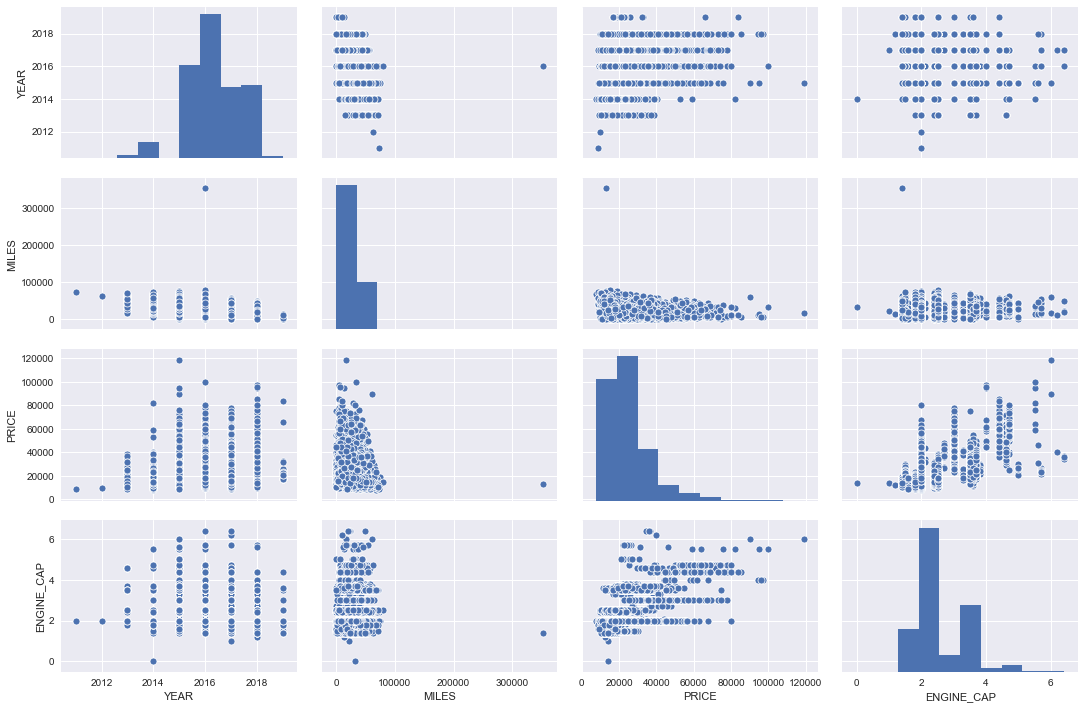

In [197]:
sns.pairplot(df_final.dropna(), height=2.5, aspect=1.5);

Ugh, it looks like there are no clear linear relationships. This tells us that although the features themselves are important (by logic/domain knowledge) we have to look into polynomial transformations and/or feature interactions to make effective use of them. We'll test this out later.

#### A look at the most popular brands in our dataset:

In [198]:
df_final['BRAND'].value_counts()

Mercedes-Benz    736
Nissan           453
BMW              399
Lexus            333
Honda            329
Volkswagen       323
Chevrolet        280
Ford             253
Cadillac         193
Toyota           190
Audi             183
INFINITI         182
Kia              157
Lincoln          154
Mazda            146
Acura            138
Buick            128
Subaru           124
Hyundai           84
Volvo             69
Chrysler          59
Dodge             52
Maserati          33
Bentley            1
Mitsubishi         1
Name: BRAND, dtype: int64

#### A look at the distribution of cars in the dataset by price:

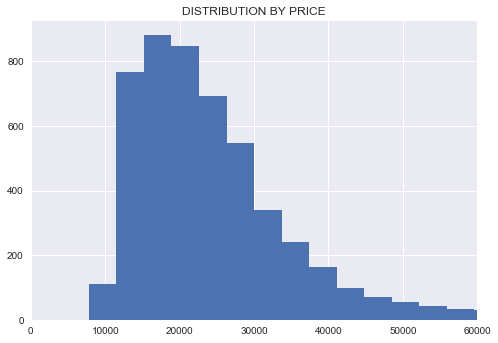

In [199]:
#temp = df_final[(df_final['PRICE']>7000) & (df_final['PRICE']<60000)]
plt.hist(df_final['PRICE'], bins=30)
plt.xlim(0,60000)
plt.title('DISTRIBUTION BY PRICE');

Most cars fall under the \\$15,000 - \\$30,000 price range.

#### A look at the distribution of cars by year of manufacture:

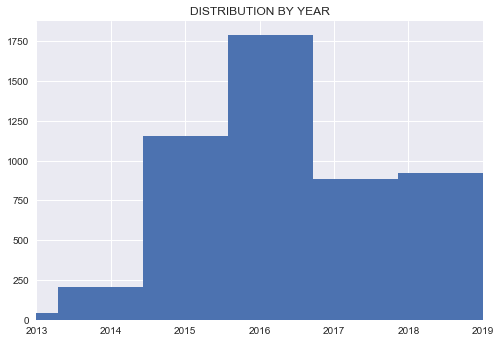

In [236]:
#temp = df_final[(df_final['PRICE']>7000) & (df_final['PRICE']<60000)]
plt.hist(df_final['YEAR'], bins = 7)
plt.xlim(2013,2019)
plt.title('DISTRIBUTION BY YEAR');

Most cars being sold are roughly 3 years old.

#### A look at the distribution of cars by the number of miles on them:

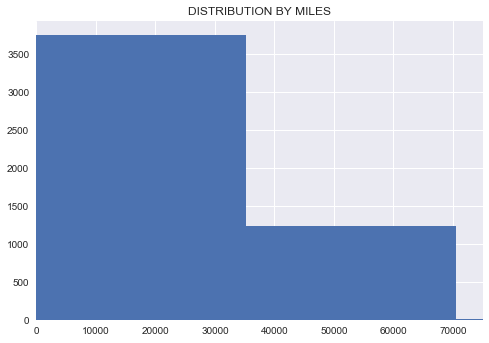

In [201]:
#temp = df_final[(df_final['PRICE']>7000) & (df_final['PRICE']<60000)]
plt.hist(df_final['MILES'])
plt.xlim(0,75000)
plt.title('DISTRIBUTION BY MILES');

It is interesting to note that there is a sharp drop in the number of cars with miles greater than around 30,000. Upon further investigation, I found that most car leases last 3 years with around 10,000 miles per year and then end up on the used car market after that.

#### A look at the distribution of cars by engine capacity:

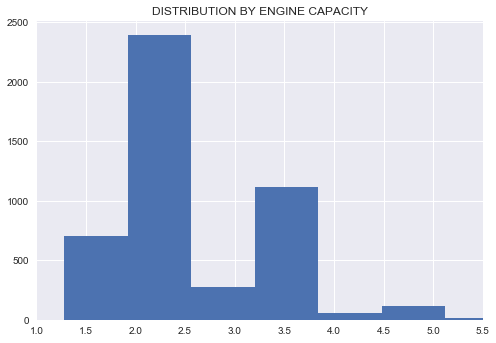

In [202]:
#temp = df_final[(df_final['PRICE']>7000) & (df_final['PRICE']<60000)]
plt.hist((df_final.dropna()).ENGINE_CAP)
plt.xlim(1,5.5)
plt.title('DISTRIBUTION BY ENGINE CAPACITY');

It is interesting to see two spikes in the above plot. This is because, for the most part, cars are divided into the commuter and the luxury types. The commuter cars come with a similar engine capacity range and the luxury cars follow the same trend (but are more powerful, hence the second spike).

#### Now that we have a clean base dataset to work with, it is always recommended to save it to disk in case we want to return to it at a later time. Pickling is a great way to preserve objects as they are in python:

In [203]:
#Pickling to save my butt in case the program crashes or something

import pickle

with open("df_final.pkl", 'wb') as picklefile: 
     pickle.dump(df_final, picklefile)

# with open("ultimate_df.pkl", 'rb') as picklefile: 
#      Ultimate_DF = pickle.load(picklefile)
# with open('data/a_batter_file.pkl', 'rb') as picklefile:
#     list_of_all_players.extend(pickle.load(picklefile))

## MODEL IMPLEMENTATION

In [204]:
#Let's make some copies so we don't mess around with the original data
df_model = df_final.copy(deep=True)

#### We have to deal with missing values before we can move further. If the number of rows with missing values is small enough, we can just drop them and move on. Let's see how many such rows exist:

In [205]:
df_model.shape[0] - df_model.dropna().shape[0]

310

It looks like we can afford to simply drop the rows and move on.

In [206]:
df_model.dropna(inplace=True)

In [207]:
df_model.dtypes

YEAR              int64
BRAND            object
MILES             int64
PRICE             int64
ENGINE_CAP      float64
TRANSMISSION     object
DRIVETRAIN       object
EXT_COLOR        object
INT_COLOR        object
dtype: object

In [208]:
df_model_features = df_model[['YEAR', 'MILES', 'BRAND', 'ENGINE_CAP', 'TRANSMISSION'
                              , 'DRIVETRAIN', 'EXT_COLOR', 'INT_COLOR']]
df_model_target = df_model['PRICE']

In [209]:
df_model.shape

(4690, 9)

#### We have to encode the categorical features before we can fit a model. There are multiple ways we can do this. We will use the "one-hot encoding" method and simply dummify such features (this creates a new column for each category of each categorical column). Each of these 'dummy' columns will hold a value of 0 or 1.
#### More on that here: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [210]:
df_model_features = pd.DataFrame(pd.get_dummies(df_model_features))

In [211]:
df_model_features.shape

(4690, 61)

Note that the number of columns went up drastically because of the encoding.

#### We will now raise the polynomial degree and compute feature interactions:

In [212]:
p = PolynomialFeatures(degree=2)
df_model_features_d2 = p.fit_transform(df_model_features)
df_model_features_d2.shape

(4690, 1953)

Woah, the number of columns just exploded to such a high value. This is because we raised the polynomial feature and computed every single feature interaction. We will bring this down to a reasonable number a little later.

#### Let's get all the appropriate feature names:

In [213]:
#Watch out, we're passing the old df here (pre degree-2 transformation)
new_columns = p.get_feature_names(df_model_features.columns)
len(new_columns)

1953

In [214]:
type(df_model_features_d2)

numpy.ndarray

We will now add the new feature names and convert it back to a data frame.

In [215]:
df_model_features_d2 = pd.DataFrame(df_model_features_d2, columns = new_columns)
df_model_features_d2.shape

(4690, 1953)

In [216]:
df_model_features_d2.head()

,1,YEAR,MILES,ENGINE_CAP,BRAND_Acura,BRAND_Audi,BRAND_BMW,BRAND_Bentley,BRAND_Buick,BRAND_Cadillac,...,INT_COLOR_Other^2,INT_COLOR_Other INT_COLOR_Red,INT_COLOR_Other INT_COLOR_Silver,INT_COLOR_Other INT_COLOR_White,INT_COLOR_Red^2,INT_COLOR_Red INT_COLOR_Silver,INT_COLOR_Red INT_COLOR_White,INT_COLOR_Silver^2,INT_COLOR_Silver INT_COLOR_White,INT_COLOR_White^2
0,1.0,2016.0,30830.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2016.0,38096.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2016.0,29492.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2016.0,41203.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2017.0,3081.0,3.6,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Although we may continue to fitting a model at this point, it is advised to scale our features before doing so:

In [217]:
#Scaling features first
std = StandardScaler()
df_model_features_d2 = pd.DataFrame(std.fit_transform(df_model_features_d2), columns=new_columns)

#### We're finally ready to begin modeling (we are going to score on the training set for now). Let's test out some models before we get to reducing the absurd number of features we're dealing with:

In [238]:
m = LinearRegression()
m.fit(df_model_features_d2, df_model_target)
m.score(df_model_features_d2, df_model_target)

0.8828726004825977

In [239]:
lasso_model = LassoCV()
lasso_model.fit(df_model_features_d2, df_model_target)
lasso_model.score(df_model_features_d2, df_model_target)

0.8526405477675314

In [240]:
ridge_model = RidgeCV()
ridge_model.fit(df_model_features_d2, df_model_target)
ridge_model.score(df_model_features_d2, df_model_target)

0.8671477708462859

#### We can look at the model coefficients to get the features that are truly making a difference:

In [241]:
#required_columns contains the indices of the columns with non-zero coefficients
i = 0
required_columns = []
for index, val in enumerate(lasso_model.coef_):
    if val!=0.0:
        #print('Index:%s, Value:%s'%(index, val))
        required_columns.append(index)
        i+=1
print('There are',i,'required columns.')

There are 325 required columns.


#### Now that we have the features we need, let's get rid of the rest:

In [242]:
#Filtering out the other columns
df_model_features_d2_final = df_model_features_d2[df_model_features_d2.columns[required_columns]]

In [243]:
df_model_features_d2_final.head()

,YEAR,BRAND_Bentley,BRAND_Cadillac,BRAND_Lexus,BRAND_Lincoln,BRAND_Maserati,BRAND_Mitsubishi,BRAND_Nissan,BRAND_Toyota,BRAND_Volvo,...,EXT_COLOR_Other INT_COLOR_Brown,EXT_COLOR_Other INT_COLOR_Other,EXT_COLOR_Other INT_COLOR_White,EXT_COLOR_Purple INT_COLOR_Beige,EXT_COLOR_Silver INT_COLOR_Beige,EXT_COLOR_Silver INT_COLOR_Black,EXT_COLOR_Silver INT_COLOR_Brown,EXT_COLOR_White INT_COLOR_Brown,EXT_COLOR_White INT_COLOR_Orange,EXT_COLOR_White INT_COLOR_White
0,-0.180477,-0.014604,-0.198621,3.676972,-0.179249,-0.084179,-0.014604,-0.317709,-0.191555,-0.11855,...,-0.014604,-0.077498,-0.020655,-0.020655,-0.095059,-0.314445,-0.032669,-0.117622,-0.0253,-0.096194
1,-0.180477,-0.014604,-0.198621,-0.271963,-0.179249,-0.084179,-0.014604,-0.317709,-0.191555,-0.11855,...,-0.014604,-0.077498,-0.020655,-0.020655,-0.095059,-0.314445,-0.032669,-0.117622,-0.0253,-0.096194
2,-0.180477,-0.014604,-0.198621,3.676972,-0.179249,-0.084179,-0.014604,-0.317709,-0.191555,-0.11855,...,-0.014604,-0.077498,-0.020655,-0.020655,-0.095059,-0.314445,-0.032669,-0.117622,-0.0253,-0.096194
3,-0.180477,-0.014604,-0.198621,3.676972,-0.179249,-0.084179,-0.014604,-0.317709,-0.191555,-0.11855,...,-0.014604,-0.077498,-0.020655,-0.020655,-0.095059,-0.314445,-0.032669,-0.117622,-0.0253,-0.096194
4,0.671929,-0.014604,5.034711,-0.271963,-0.179249,-0.084179,-0.014604,-0.317709,-0.191555,-0.11855,...,-0.014604,-0.077498,-0.020655,-0.020655,-0.095059,-0.314445,-0.032669,-0.117622,-0.0253,-0.096194


It may look like the data doesn't make sense, but that's because we have scaled it for consistency.

In [244]:
lasso_temp = LassoCV()
lasso_temp.fit(df_model_features_d2_final, df_model_target)
lasso_temp.score(df_model_features_d2_final, df_model_target)

0.8574714725962475

#### Let's do a basic train/test split to see if the performance is consistent (though LassoCV/RidgeCV employs cross-validation, it doesn't hurt to have a holdout set):

In [245]:
X_train, X_test, Y_train, Y_test = train_test_split(df_model_features_d2_final, df_model_target
                                                    , test_size=0.1, random_state=42)

In [246]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4221, 325)
(469, 325)
(4221,)
(469,)


In [247]:
m_2 = LinearRegression()
m_2.fit(X_train, Y_train)
m_2.score(X_train, Y_train)

0.870849432206049

In [248]:
lasso_model_2 = LassoCV()
lasso_model_2.fit(X_train, Y_train)
lasso_model_2.score(X_test, Y_test)

0.8351887629586059

In [249]:
ridge_model_2 = RidgeCV()
ridge_model_2.fit(X_train, Y_train)
ridge_model_2.score(X_test, Y_test)

0.8375739909489468

The score is expected to fall when we score on test, but the scores look more or less consistent. We can now move on to visualize our results.

### Now, let's take a moment to interpret our results and the model performance:

#### A look at the residuals will tell us how the model is doing for a range of target prices:

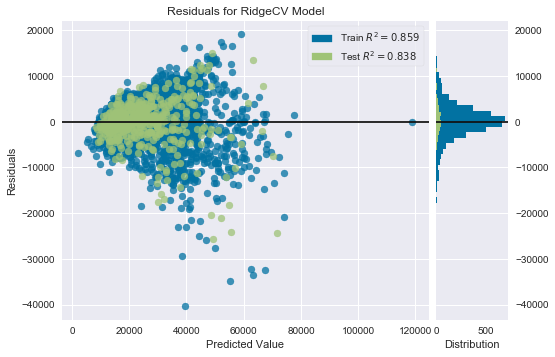

In [250]:
ridge_model_viz = RidgeCV()
visualizer = ResidualsPlot(ridge_model_viz, hist=True)
visualizer.fit(X_train, Y_train)
visualizer.score(X_test, Y_test)
visualizer.poof()



Although in theory, heteroscedasticity is not a good sign, in practice it is almost always visible. In the above plot, for good predictions, we must ensure that most of the data points are as close as possible to the zero line. As we can see, the greatest density of points is around the zero line and the spread increases as we move towards the more expensive cars. This is because the original dataset has fewer expensive cars as we move up in price and hence fewer data points to train the model with. In such cases, the model is expected to do poorly in such areas.

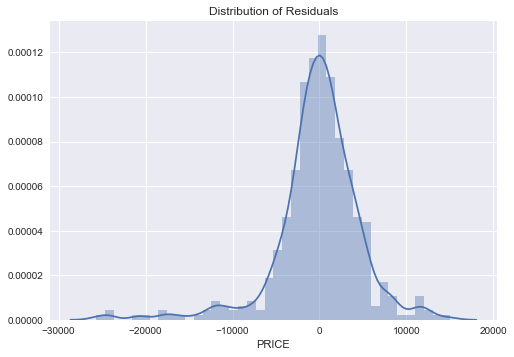

In [251]:
sns.distplot((ridge_model_2.predict(X_test)-Y_test), bins=40).set_title('Distribution of Residuals');

#### Features that drive (pun intended) up the price the most:

In [252]:
#Analyzing most important features
pd.DataFrame({'Column_Name': new_columns
              , 'Coefficient': lasso_model.coef_}).sort_values(['Coefficient'], ascending=False).head(5)

,Column_Name,Coefficient
183,ENGINE_CAP^2,4775.300741
202,ENGINE_CAP BRAND_Mercedes-Benz,4599.222229
186,ENGINE_CAP BRAND_BMW,4261.374407
1,YEAR,2407.065822
20,BRAND_Maserati,1428.566030


As expected, the more powerful the car, the more expensive it is. Some of the other features that drive the price up are if it is a powerful luxury car, if the manufacture year is more recent or if it is a sports car brand like Maserti.

#### Similarly, the features that drive the price down:

In [253]:
pd.DataFrame({'Column_Name': new_columns
              , 'Coefficient': lasso_model.coef_}).sort_values(['Coefficient'], ascending=True).head(5)

,Column_Name,Coefficient
35,DRIVETRAIN_FWD,-2464.821136
143,MILES BRAND_Mercedes-Benz,-1736.885414
127,MILES BRAND_BMW,-1479.714544
124,MILES ENGINE_CAP,-1373.612307
192,ENGINE_CAP BRAND_Dodge,-1272.762751


#### Finally, for the lulz, I wrote a piece of code that repeatedly reduces the number of columns as the dataset is trained on a set that contains fewer and fewer columns (Spoiler Alert: We hit the point of diminishing returns real fast):

In [255]:
#Don't bother with this yet
xtr = X_train.copy(deep=True)
xte = X_test.copy(deep=True)
counter = 0
no_cols = 1
prev_no_cols = 0
while no_cols != 0:
    counter += 1
    print('Run Number:', counter)
    print('Train Shape:', xtr.shape)
    print('Test Shape:', xte.shape)
    las_m = LassoCV()
    las_m.fit(xtr, Y_train)
    print('Score: ', las_m.score(xte, Y_test))
    no_cols = 0
    req_columns = []
    for index, val in enumerate(las_m.coef_):
        if val!=0.0:
            #print('Index:%s, Value:%s'%(index, val))
            req_columns.append(index)
            no_cols+=1
    if no_cols == prev_no_cols:
        print('No more columns to drop.')
        break
    prev_no_cols = no_cols
    print('There are',no_cols,'required columns.\n')
    xtr = xtr[xtr.columns[req_columns]]
    xte = xte[xte.columns[req_columns]]
    

    
    
    


Run Number: 1
Train Shape: (4221, 325)
Test Shape: (469, 325)
Score:  0.8351887629586059
There are 296 required columns.

Run Number: 2
Train Shape: (4221, 296)
Test Shape: (469, 296)
Score:  0.8351890197654549
There are 294 required columns.

Run Number: 3
Train Shape: (4221, 294)
Test Shape: (469, 294)
Score:  0.835189019431776
No more columns to drop.


## Future Research:
- Try other models and tune using hyperparameters
- Build out the extensive dataset using independent filters and expand to include other automobile types 
- Include data from sources other than www.cars.com
- Perform in-depth outlier analysis